# Проект: Анализ бизнес-показателей рекламных кампаний приложения

### 0. Описание проекта

**Цель проекта:** выявить причины убытков по результатам рекламных компаний приложения, которые проводятся в нескольких каналах.


**Задачи**:
- Расчитать экономические результаты рекламных кампаний в разрезе каналов.
- Проанализировать результаты, выявить причины убытка.


**Данные:**

visits_info_short.csv - лог с информацией о посещениях сайта
- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии

orders_info_short.csv - информация о покупках пользователей
- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.

costs_info_short.csv - информация о раходах на рекламу
- dt — дата проведения рекламной кампании,
- Channel — идентификатор рекламного источника,
- costs — расходы на эту кампанию.

**План работы**
1. Загрузка и предобработка исходных данных;
2. Подготовка функций для построения метрик;
3. Исследовательский анализ данных: формирование профилей пользователей, верхнеуровневое рассмотрение стран, устройтв и каналов привлечения пользователей;
4. Анализ расходов на маркетинг: в целом и по разрезам из пункта 3;
5. Оценка окупаемости рекламы по LTV, ROI, CAC;
6. Выводы.

### 1. Загрузим данные и подготовим их к анализу

In [1]:
# Импортируем библиотеки, которые будем в дальнейшем использовать в работе
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

*По NDA Практикума я не могу публиковать датасеты, поэтому здесь нет полной ссылки на них*

In [2]:
# Импортируем файлы в переменные
visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')  #визиты
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')  #заказы
costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')  #расходы

#### 1.1. Изучим данные по визитам

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Пропуски отсутствуют.

In [4]:
visits.head(5)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [5]:
#Нормализуем названия столбцов
visits = visits.rename(columns={"User Id": "user_id", "Region": "region", "Device": "device", "Channel" : "channel", "Session Start" : "session_start", "Session End" : "session_end"})

In [6]:
#Проверим нет ли полных дубликатов
visits.duplicated().sum()

0

Полные дубликаты отсутствуют.

In [7]:
#Скорректируем тип данных в столбцах с началом и окончанием сессии
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [8]:
#Посмотрим инфо по обновленной таблице
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


Названия столбцов и типы данных скорректированы.

#### 1.2. Изучим данные по заказам

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Пропуски отсутствуют.

In [10]:
orders.head(5)

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [11]:
#Нормализуем названия столбцов
orders = orders.rename(columns={"User Id": "user_id", "Event Dt": "event_dt", "Revenue": "revenue"})

In [12]:
#Проверим нет ли полных дубликатов
orders.duplicated().sum()

0

Полные дубликаты отсутствуют.

In [13]:
#Скорректируем тип данных в столбцах со временем покупки
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [14]:
#Посмотрим инфо по обновленной таблице
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


Названия столбцов и типы данных скорректированы.

#### 1.3. Изучим данные по затратам

In [15]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Пропуски отсутствуют.

In [16]:
costs.head(5)

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [17]:
#Нормализуем название столбца
costs = costs.rename(columns={"Channel": "channel"})

In [18]:
#Проверим нет ли полных дубликатов
costs.duplicated().sum()

0

Полные дубликаты отсутствуют.

In [19]:
#Посмотрим инфо по обновленной таблице
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Название столбца скорректировано.

### 2. Пропишем функции для расчёта и анализа LTV, ROI, удержания и конверсии

Для вычисления метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

#### 2.1. Функция get_profiles() для создания профилей пользователей

In [20]:
def get_profiles(sessions, orders, ad_costs):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )
    new_users['dt'] = pd.to_datetime(new_users['dt'])

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs['dt'] = pd.to_datetime(ad_costs['dt'])
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles['dt'] = pd.to_datetime(profiles['dt'])
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles  # возвращаем профили с CAC

In [21]:
profiles = get_profiles(visits, orders, costs)

In [22]:
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


#### 2.2. Функция get_retention() для подсчета Retention Rate

In [23]:

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time



#### 2.3. Функция get_conversion() для подсчета конверсии

In [24]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time


#### 2.4. Функция get_ltv() для подсчета ltv

In [25]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

#### 2.5. Функция filter_data() для сглаживания данных

In [26]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

#### 2.6. Функция plot_retention() для построения графика Retention Rate

In [27]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

#### 2.7. Функция plot_conversion() для построения графика конверсии

In [28]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

#### 2.8. Функциюя plot_ltv_roi для визуализации LTV и ROI

In [29]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### 3. Исследовательский анализ данных

#### 3.1. Cформируем профили пользователей

In [30]:
profiles = get_profiles(visits, orders, costs)

In [31]:
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


**3.2. Определим минимальную и максимальную дату привлечения пользователей**

In [32]:
print("Минимальная дата привлечения:", profiles['dt'].min())
print("Максимальная дата привлечения:", profiles['dt'].max())

Минимальная дата привлечения: 2019-05-01 00:00:00
Максимальная дата привлечения: 2019-10-27 00:00:00


Минимальная и минимальная даты привлечения пользователей соответствуют описанному в условиях периоду с 1 мая по 27 октября 2019 года.

#### 3.3. Выясним, из каких стран пользователи приходят в приложение

In [33]:
p = (profiles.pivot_table(index='region', values=['payer'*1], aggfunc=['count','sum','mean'], )
 .sort_values(by = ('sum','payer'), ascending=False)
)
p['mean','payer'] = p['mean','payer'].map('{:.2%}'.format)
p

,count,sum,mean
,payer,payer,payer
region,,,
United States,100002,6902,6.90%
UK,17575,700,3.98%
France,17450,663,3.80%
Germany,14981,616,4.11%


Больше всего покупателей приходят в приложение из США, кроме того у этой же страны наибольшая доля платящих клиентов.

#### 3.4. Выясним, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи.

In [34]:
p = (profiles.pivot_table(index='device', values=['payer'*1], aggfunc=['count','sum','mean'], )
 .sort_values(by = ('sum','payer'), ascending=False)
)
p['mean','payer'] = p['mean','payer'].map('{:.2%}'.format)
p

,count,sum,mean
,payer,payer,payer
device,,,
iPhone,54479,3382,6.21%
Android,35032,2050,5.85%
Mac,30042,1912,6.36%
PC,30455,1537,5.05%


Больше всего платящих пользователей приходят с iPhone. Однако лучше всего конвертируются пользователи MAC, хотя их меньше всего. 
Возможные причины:\
а) Большая часть покупателей приходит из США, а там IPhone и MAC более популярны.\
б) iPhone и MAC пользуются более платежеспособные клиенты.\
в) На этих устройствах лучше выстроен клиентский путь.\
Интуитивно склоняюсь к варианту а.

#### 3.5. Определим каналы, из которых пришло больше всего платящих пользователей

In [35]:
p=(
  profiles.pivot_table(index='channel', values=['payer'*1], aggfunc=['count','sum','mean'], )
 .sort_values(by = ('sum','payer'), ascending=False)
)
p['mean','payer'] = p['mean','payer'].map('{:.2%}'.format)
p

,count,sum,mean
,payer,payer,payer
channel,,,
FaceBoom,29144,3557,12.20%
TipTop,19561,1878,9.60%
organic,56439,1160,2.06%
WahooNetBanner,8553,453,5.30%
AdNonSense,3880,440,11.34%
RocketSuperAds,4448,352,7.91%
LeapBob,8553,262,3.06%
OppleCreativeMedia,8605,233,2.71%


Больше всего платящих пользователей приходит с ресурса FaceBoom, они же лучше всего конвертируются. 
На втором месте по конвертации lambdaMediaAds - кажется, если бы мы привлекали больше пользователей оттуда, могли бы нарастить и число покупателей, но для окончательных выводов нужно посмотреть на CAC и LTV.

Значительное число покупателей приходится и на органический траффик, но конверсия в покупателей у этого канала ожидаемо наименьшая.

### 4. Маркетинг

#### 4.1. Посчитаем общую сумму расходов на маркетинг

In [36]:
'{:.0f}'.format(costs['costs'].sum())

'105497'

Общая сумма расходов на маркетинг 105 тысяч у.е.

#### 4.2. Выясним, как траты распределены по рекламным источникам

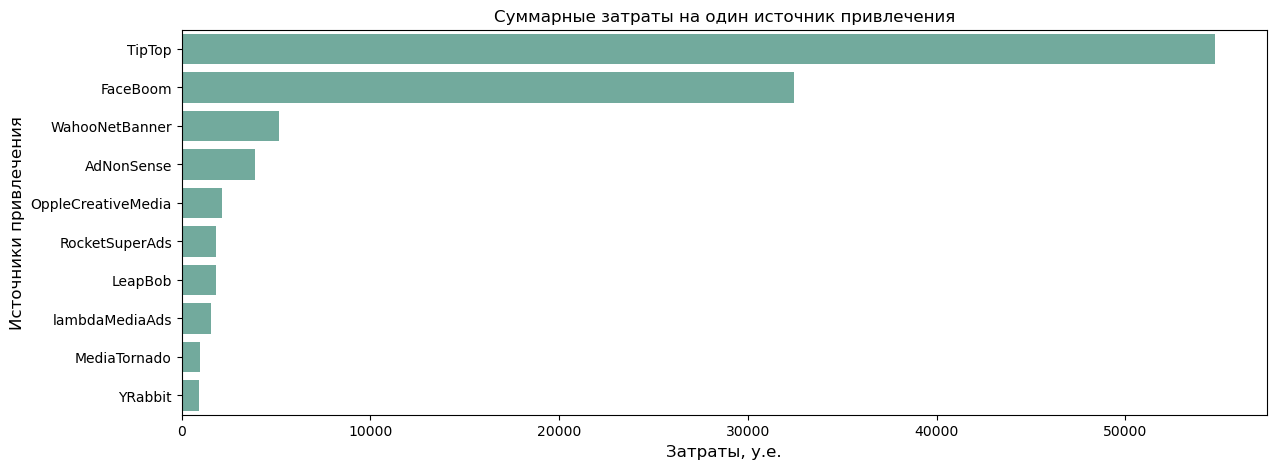

In [37]:
fig, bp = plt.subplots(figsize=(14, 5))

sns.barplot(
    y="channel", 
    x="costs", 
    data=(costs.pivot_table(index='channel', values='costs', aggfunc='sum').reset_index()
          .sort_values(by = 'costs', ascending=False)), 
    estimator=sum, 
    ci=None,
    color='#69b3a2').set(
    title="Суммарные затраты на один источник привлечения")

bp.set_xlabel( "Затраты, у.е.", size = 12 )
bp.set_ylabel( "Источники привлечения", size = 12 )

plt.show()

По объему расходов с большим отрывом лидируют TipTop и FaceBoom - эти же источники лидируют по числу привлечения платящих клиентов.

#### 4.3. Рассмотрим динамику изменения расходов

In [38]:
#Добавим столбец с неделями в profiles
profiles['week'] = profiles['dt'].dt.isocalendar().week

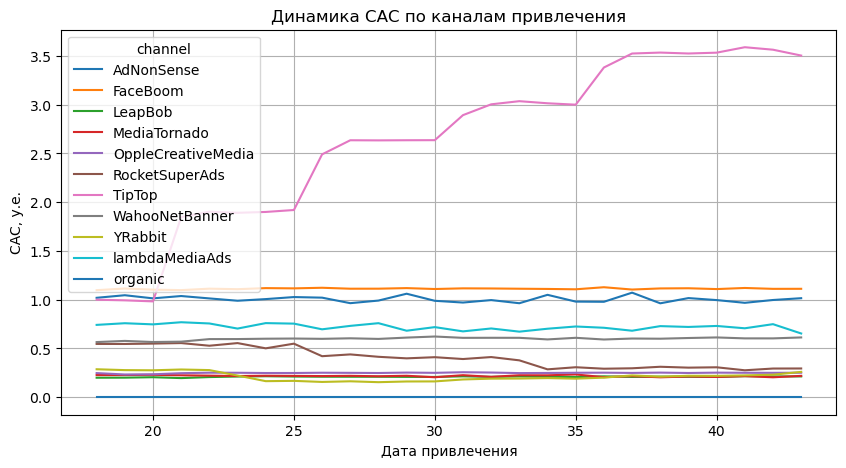

In [39]:
profiles.pivot_table(
    index='week', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, у.е.')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

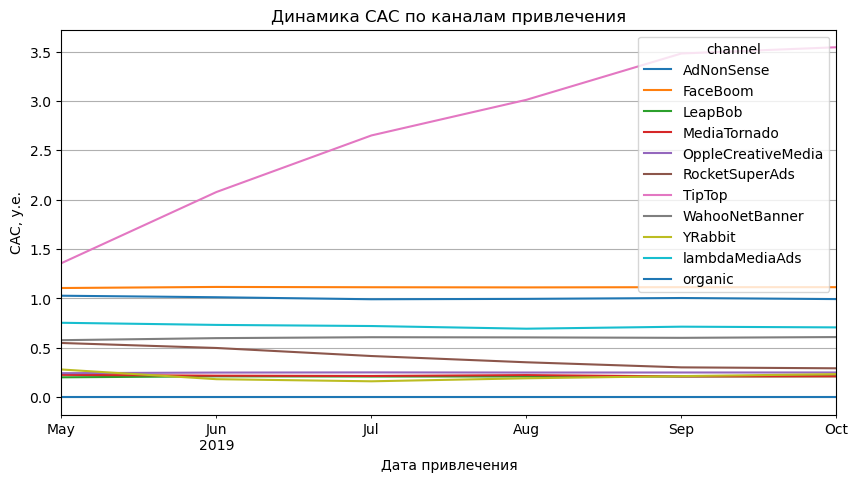

In [40]:
profiles.pivot_table(
    index='month', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, у.е.')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

Судя по графику, с мая по октябрь экспоненциально растут расходы на продвижение в TipTop.

#### 4.4. Рассмотрим CAC в разрезе источников

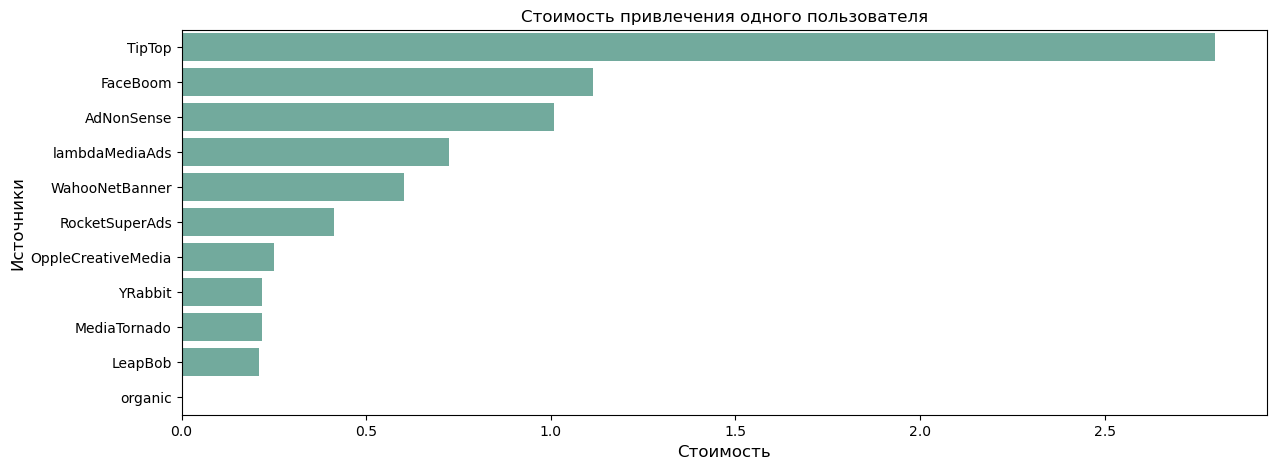

In [41]:
fig, bp = plt.subplots(figsize=(14, 5))

sns.barplot(
    y="channel", 
    x="acquisition_cost", 
    data=(profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc='mean').reset_index()
              .sort_values(by='acquisition_cost', ascending=False)), 
    estimator=sum, 
    ci=None,
    color='#69b3a2').set(
    title="Стоимость привлечения одного пользователя")

bp.set_xlabel( "Стоимость", size = 12 )
bp.set_ylabel( "Источники", size = 12 )

plt.show()

In [42]:
(profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc='mean').reset_index()
              .sort_values(by='acquisition_cost', ascending=False))

,channel,acquisition_cost
6,TipTop,2.799003
1,FaceBoom,1.113286
0,AdNonSense,1.008054
9,lambdaMediaAds,0.724802
7,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
4,OppleCreativeMedia,0.250000
8,YRabbit,0.218975
3,MediaTornado,0.218717
2,LeapBob,0.210172


Итоговая стоимость привлечения пользователя из TipTop более чем в 2 раза превышает стоимость привлечения из любого другого источника.

### 5. Оценим окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Учитываем, что **исследование проводится 1 ноября 2019 года**, а в бизнес-плане заложено, что **пользователи должны окупаться не позднее чем через две недели после привлечения**. 

**Горизонт анализа: 14 дней** - это максимальный срок окупаемости клиента, заложенный в бизнес-план.\
**Момент анализа: 1 ноября 2019 года** - дата проведения анализа.

In [43]:
#Зафиксируем момент и горизонт анализа в переменных
observation_dt = datetime(2019, 11, 1).date()
horizon = 14

#### 5.1. Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI

In [44]:
#Исключим из profiles бесплатный органический трафик перед дальнейшим анализом окупаемости
profiles = profiles.query("channel != 'organic'")

In [45]:
# получаем сырые данные, таблицы LTV и ROI, а также таблицы динамики LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_dt, horizon, dimensions=[])

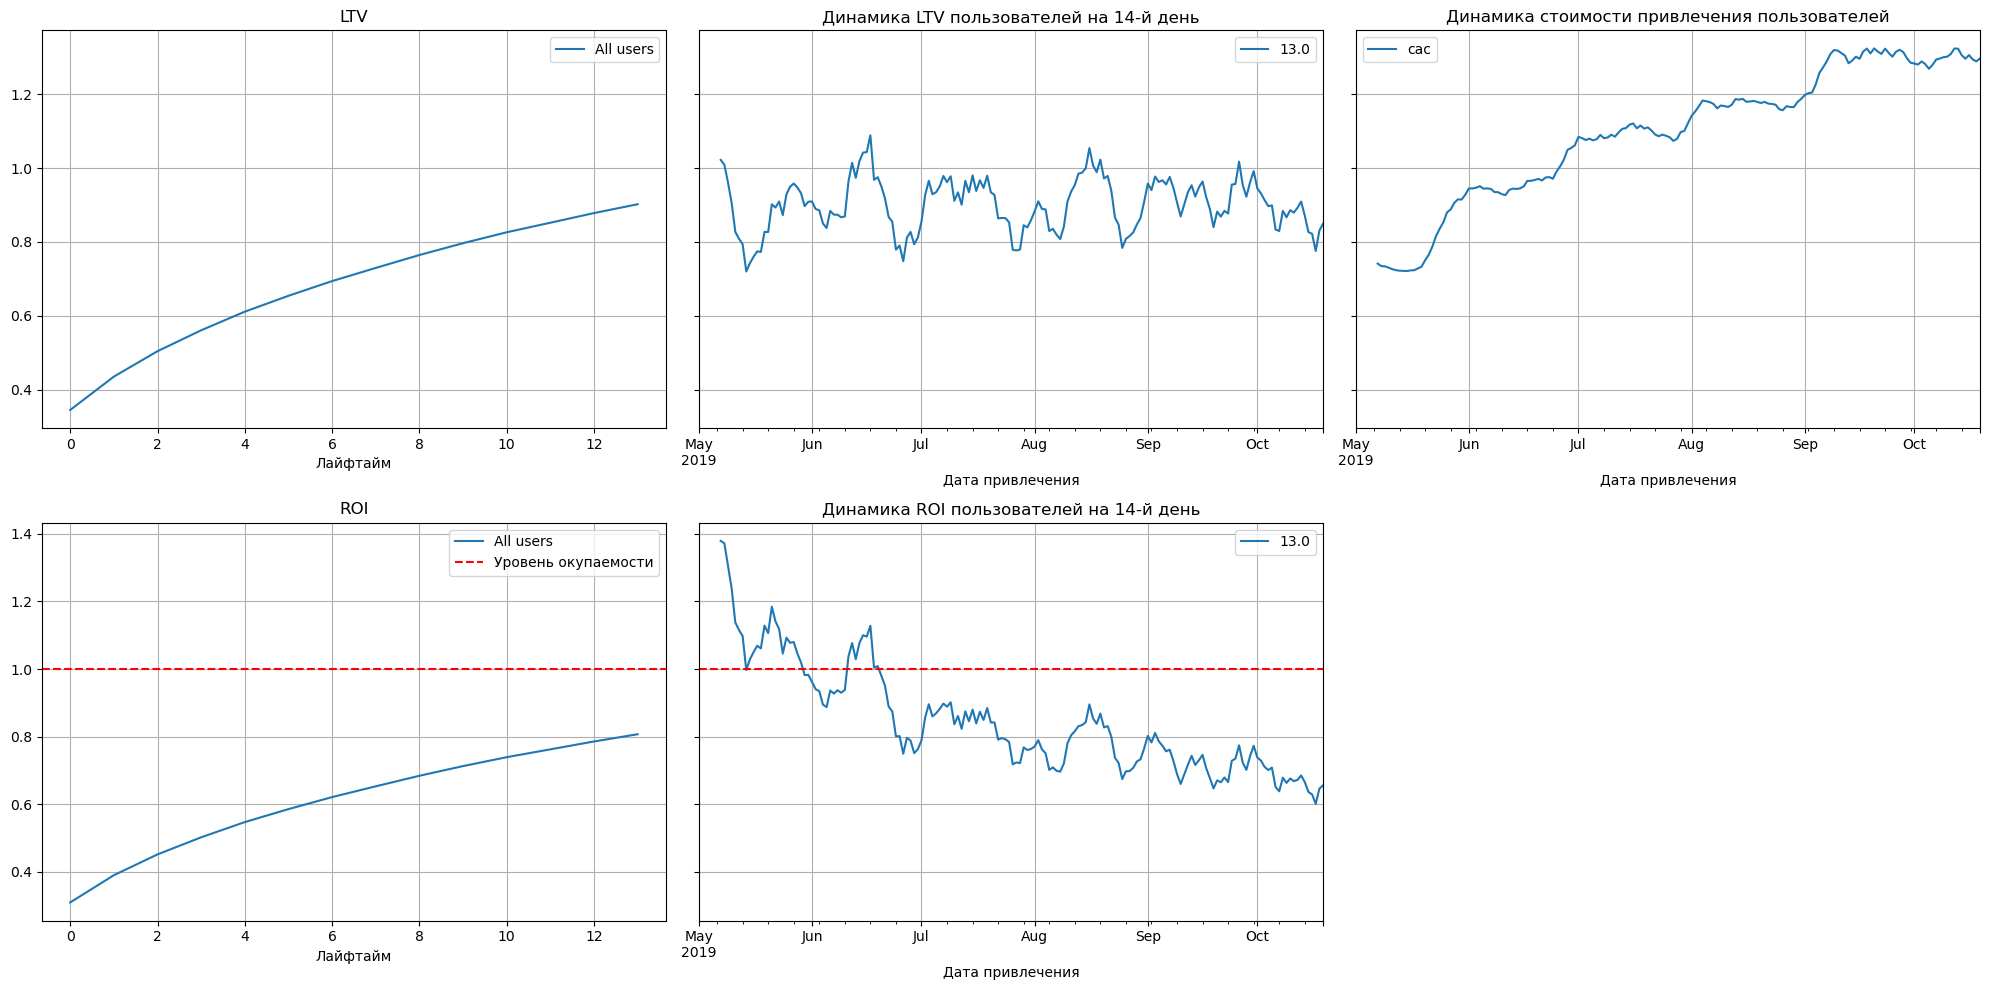

In [46]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14) 

На всём периоде наблюдения с мая по ноябрь наблюдаем тренд на снижение ROI с пересечением уровня окупаемсти в июле.\
Динамика ROI обратно пропорциональна динамике CAC. С учетом того, что динамика LTV достаточно стабильна, можно предположить, что именно рост расходов на привлечение спровоцировал падение окупаемости.

#### 5.2. Проверим конверсию и удержание пользователей и динамику их изменения

In [47]:
#Получаем сырые данные и динамику конверсии
conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    observation_dt, 
    horizon,
    dimensions=[],
)

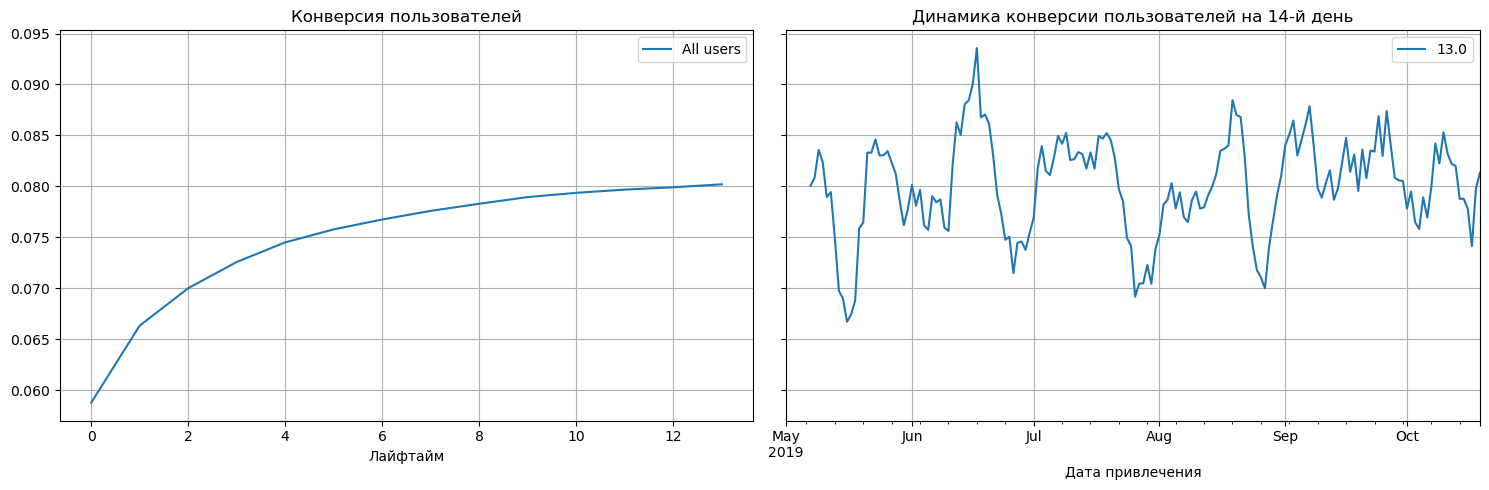

In [48]:
#Сформируем график конверсии пользователей по лайфтаймам и в динамике по месяцам
plot_conversion(conversion, conversion_history, 14) 

Конверсия ожидаемо растет по лайфтаймам. Если не смотреть на сезонные колебания, она в целом стабильна.

In [49]:
#Получаем данные удержания пользователей
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_dt, horizon, dimensions=[]
)

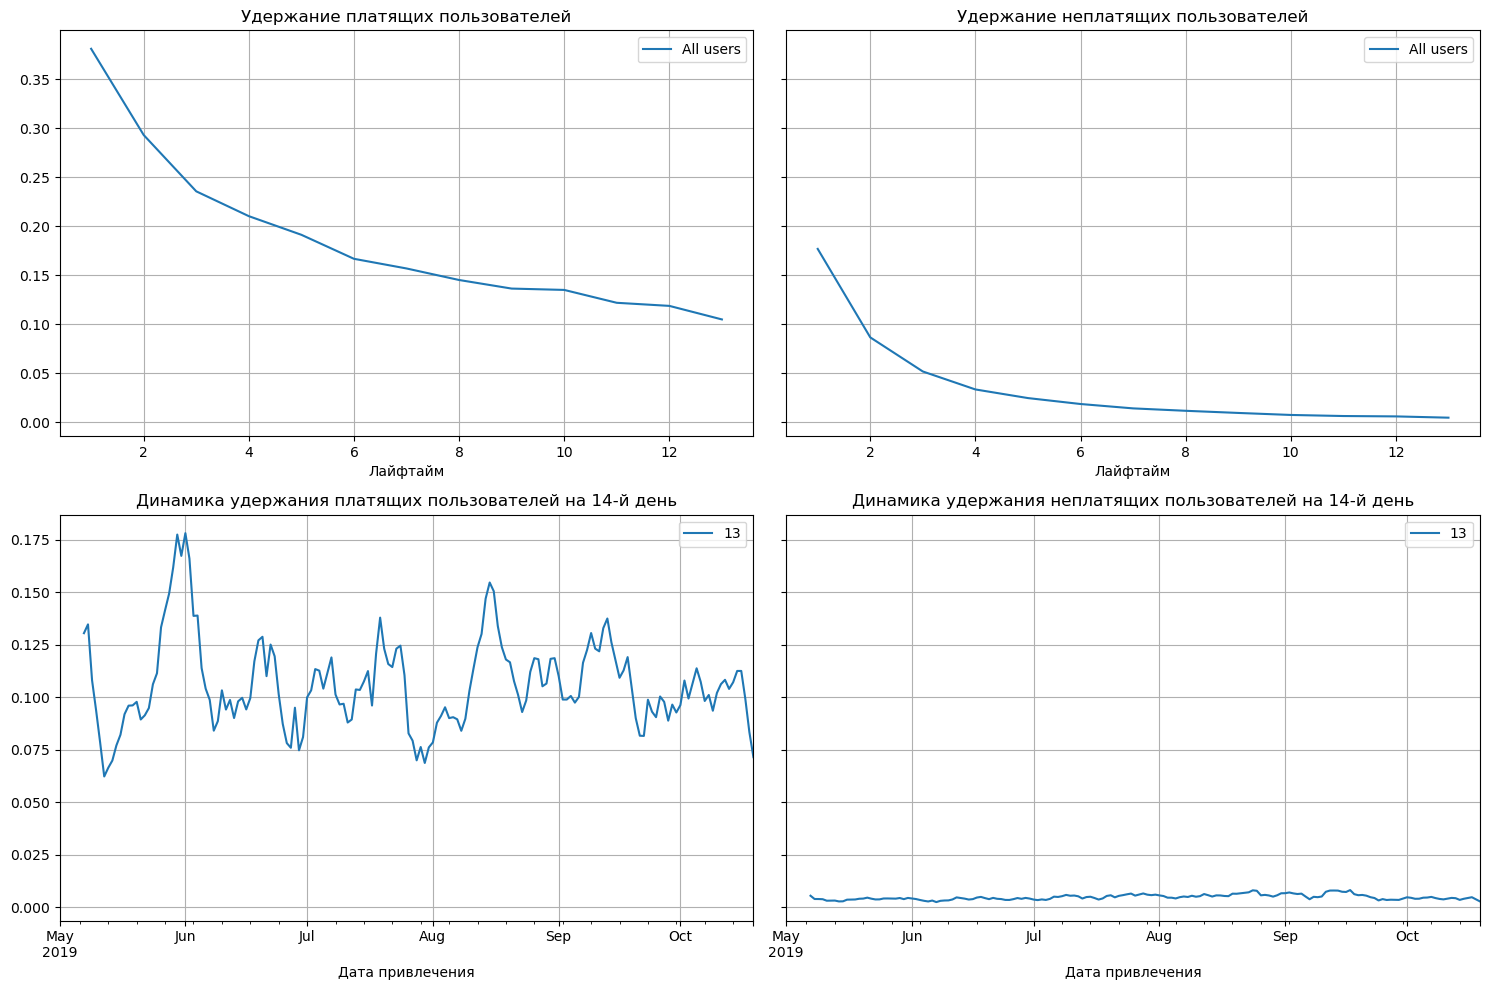

In [50]:
#Сформируем график удержания пользователей по лайфтаймам и в динамике по месяцам
plot_retention(retention, retention_history, 14) 

Кривые удержания по лайфтаймам снижаются - это нормально.\
Помесячная динамика удержания "скачет".

#### 5.3. Проанализируем окупаемость рекламы с разбивкой по устройствам

In [51]:
# получаем сырые данные, таблицы LTV и ROI, а также таблицы динамики LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_dt, horizon, dimensions=['device'])

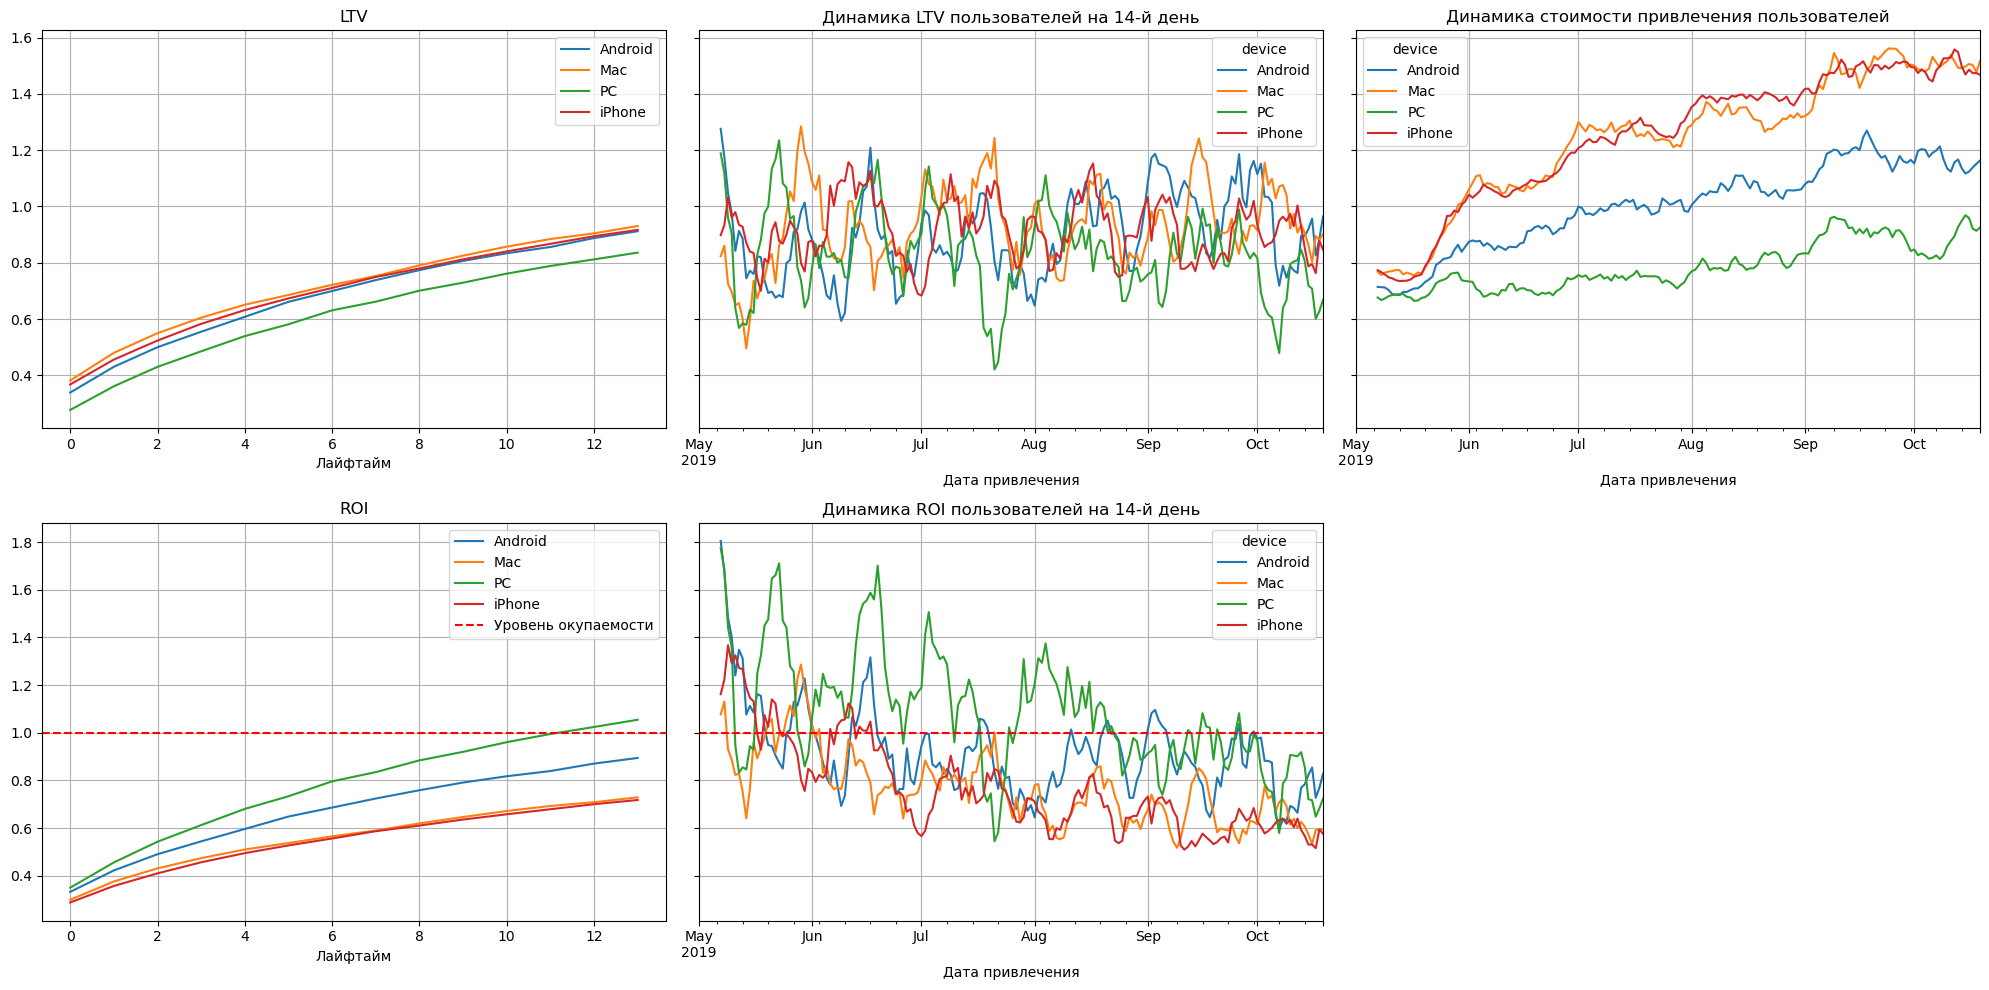

In [52]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14) 

Видим, что LTV по лайфтаймам стабильно выше у пользователей MAC и iPhone, а ниже всего у ПК. Выраженного тренда в динамике LTV нет.\
Стоимость привлечения с июня сильно выросла по всем устройствам, но по Mac и iPhone сильнее - увеличился разрыв с Android и PC.\
ROI у PC и Android пересекает уровень окупаемости, а у Mac и iPhone нет. Распределение устройств по окупаемости обратно распределению по стоимости привлечения, из чего можно предположить, что стоимость привлечения оказывает наибольшее негативное влияние на отсутвие окупаемости.

#### 5.4. Проанализируем окупаемость рекламы с разбивкой по странам

In [53]:
# получаем сырые данные, таблицы LTV и ROI, а также таблицы динамики LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_dt, horizon, dimensions=['region'])

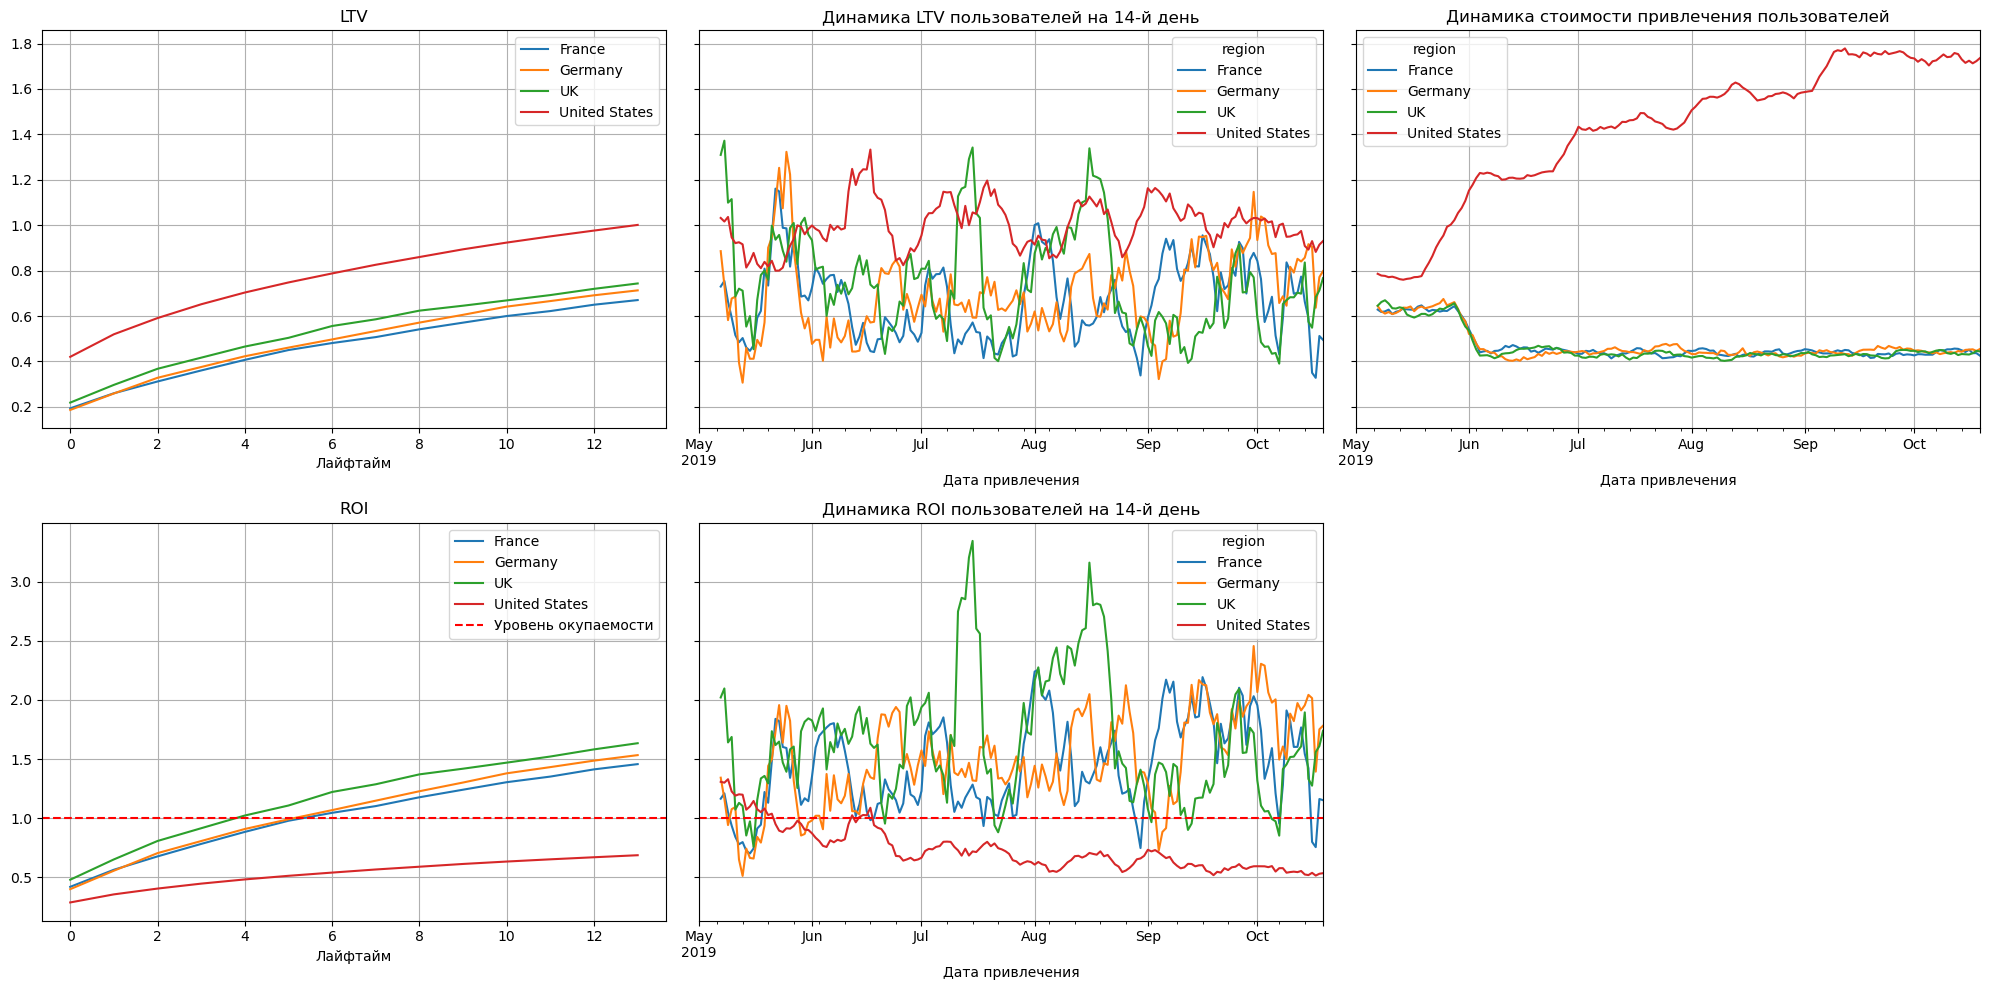

In [54]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14) 

При анализе по странам вновь подтверждается гипотеза о негативном влиянии  CAC на ROI, но в дополнении мы наблюдаем стабильный CAC и ROI по всем странам, кроме США, т.е. можно предположить, что выросли расходы на привлечение через американский ресурс.

#### 5.5. Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

In [55]:
# получаем сырые данные, таблицы LTV и ROI, а также таблицы динамики LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_dt, horizon, dimensions=['channel'])

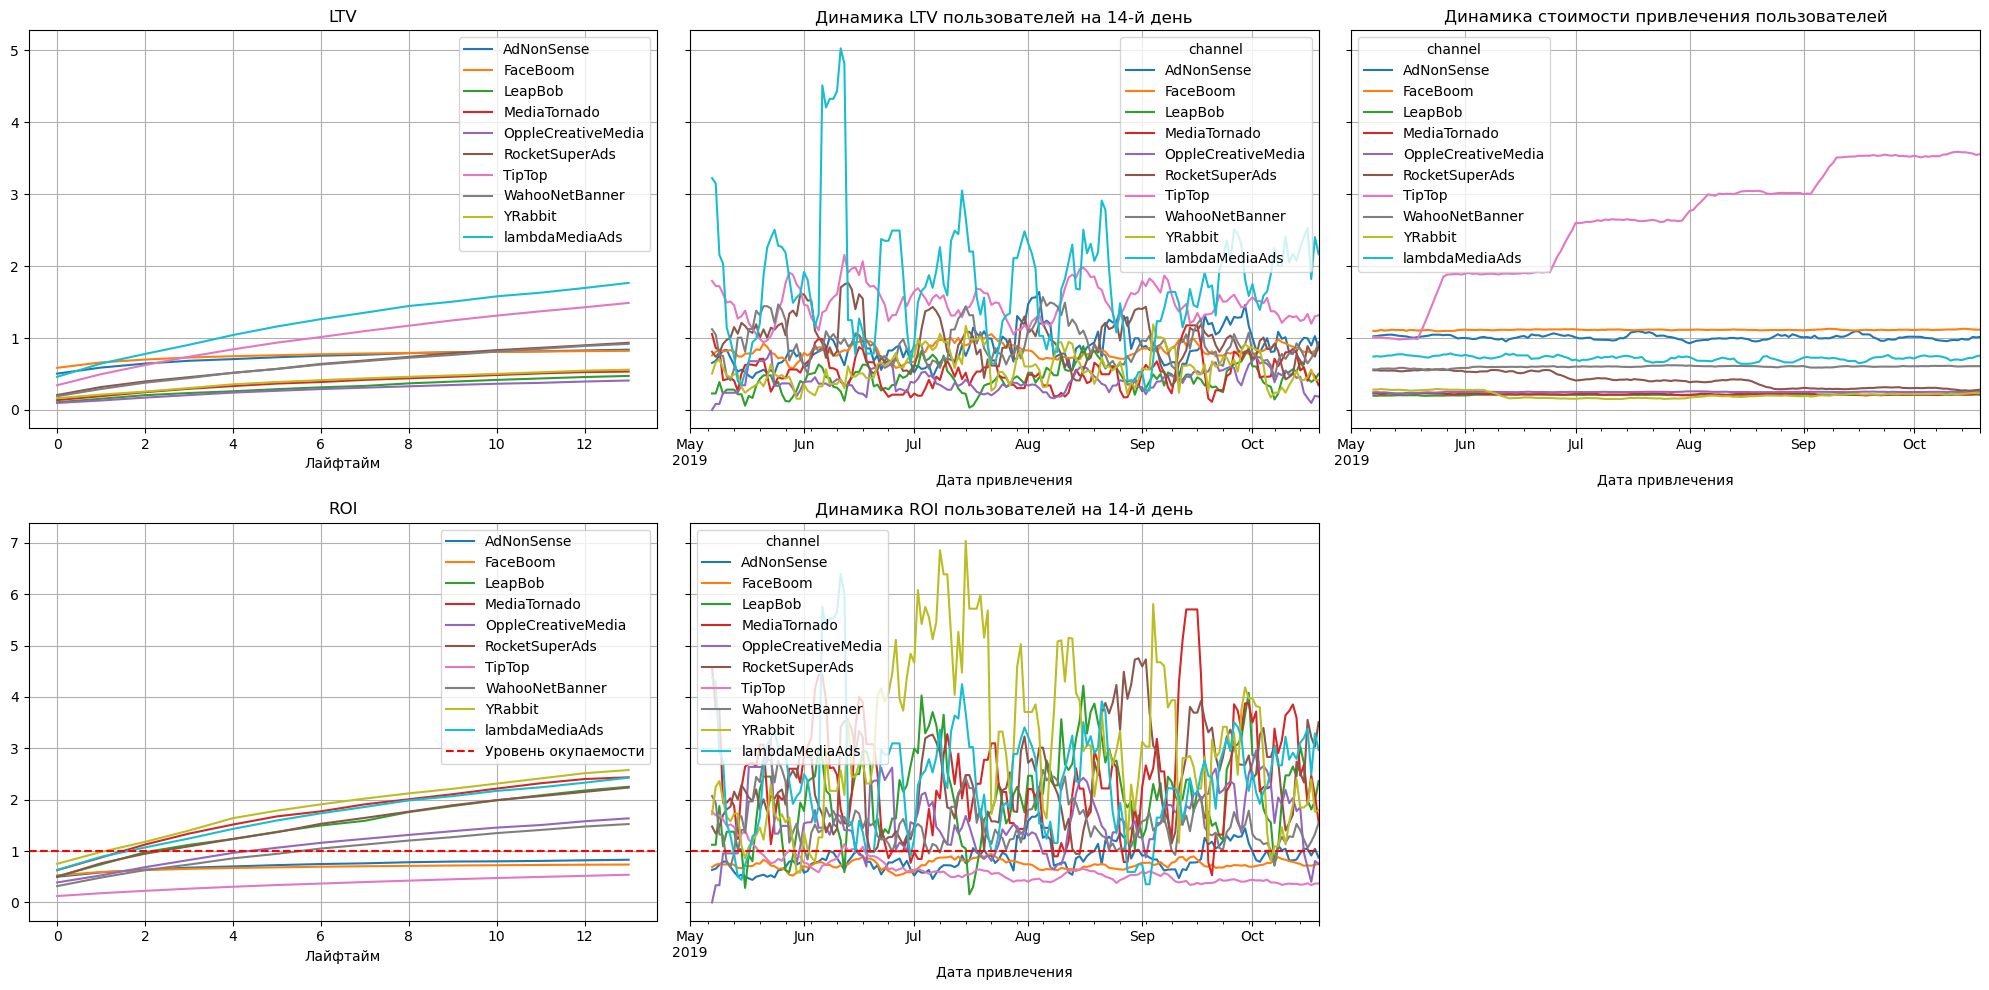

In [56]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14) 

В разбивке по каналам привлечения видим, что главный драйвер отрицательной динамики - это ресурс **TipTop**, в него инвестировали слишком много.\
У пользователей, пришедших из TipTop, в мае был один из самых высоких LTV, вероятно, поэтому маркетологи решили вложить в него больше средств, однако уже в середине мая потенциал этого канала был исчерпан и его ROI не выходил на окупаемость.

Есть вопросы и к вложениям в **FaceBoom** и **AdNonSense**, видится, что от привлечения в этих ресурсах можно отказаться:
- по суммарным расходам на привлечение они находятся на 2-м и 4-м месте, 
- при этом LTV на 14-м лайфтайме у пользователей AdNonSens самый низкий, 
- ROI FaceBoom и AdNonSense никогда не пересекают черту окупаемости.

In [57]:
p = (profiles.query("channel in ('TipTop','FaceBoom')")
     .pivot_table(index=['channel','region'], values=['payer'*1], aggfunc=['count','sum','mean']))
p['mean','payer'] = p['mean','payer'].map('{:.2%}'.format)
p

,,count,sum,mean
,,payer,payer,payer
channel,region,,,
FaceBoom,United States,29144,3557,12.20%
TipTop,United States,19561,1878,9.60%


In [58]:
(profiles.query("region == 'United States'").pivot_table(index=['region','channel'], values=['payer'*1], aggfunc=['count','sum'])
 .sort_values(by=('sum','payer'), ascending=False)
)

count   sum
                              payer payer
region        channel                    
United States FaceBoom        29144  3557
              TipTop          19561  1878
              RocketSuperAds   4448   352
              YRabbit          4312   165
              MediaTornado     4364   156

79% покупателей из США были привлечены ресурсами TipTop и FaceBoom. При этом США - единственная страна, с которой работают эти сайты. По этой причине динамика показателей США так сильно коррелирует с динамикой показателей этих ресурсов.

In [59]:
(profiles.query("channel in ('TipTop','FaceBoom')").pivot_table(index=['channel','device'], values=['payer'*1], aggfunc=['count','sum'])
.sort_values(by=['channel',('sum','payer')], ascending=False)
)

count   sum
                  payer payer
channel  device              
TipTop   iPhone    8840   827
         Mac       4820   439
         Android   3889   409
         PC        2012   203
FaceBoom iPhone   12996  1530
         Mac       7265   886
         Android   5875   784
         PC        3008   357

In [60]:
(profiles.query("device in ('iPhone','Mac')").pivot_table(index=['device','channel'], values=['payer'*1], aggfunc=['count','sum'])
 .sort_values(by=['device',('sum','payer')], ascending=False)
)

count   sum
                           payer payer
device channel                        
iPhone FaceBoom            12996  1530
       TipTop               8840   827
       RocketSuperAds       1917   168
       AdNonSense            798    91
       WahooNetBanner       1711    79
       MediaTornado         1927    65
       YRabbit              1868    64
       lambdaMediaAds        433    55
       OppleCreativeMedia   1701    52
       LeapBob              1691    41
Mac    FaceBoom             7265   886
       TipTop               4820   439
       RocketSuperAds       1137    97
       MediaTornado         1105    44
       YRabbit              1097    41
       WahooNetBanner        856    40
       AdNonSense            410    39
       OppleCreativeMedia    882    34
       LeapBob               880    27
       lambdaMediaAds        241    26

70% пользователей и 68% покупателей, привлеченных TipTop и FaceBoom, используют iPhone и Mac.\
И наоборот 70% покупателей, использующих iPhone и Mac, пришли с TipTop и FaceBoom.\
Мы ранее уже выявили, что значительная доля пользователей IPhone и MAC приходится на США, поэтому логично, что есть корреляция ежду негативными показателями пользователей iPhone и Mac и покупателей, пришедших с TipTop и FaceBoom.

In [61]:
#Рассмотрим динамику конверсии по каналам
conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['channel'],
)

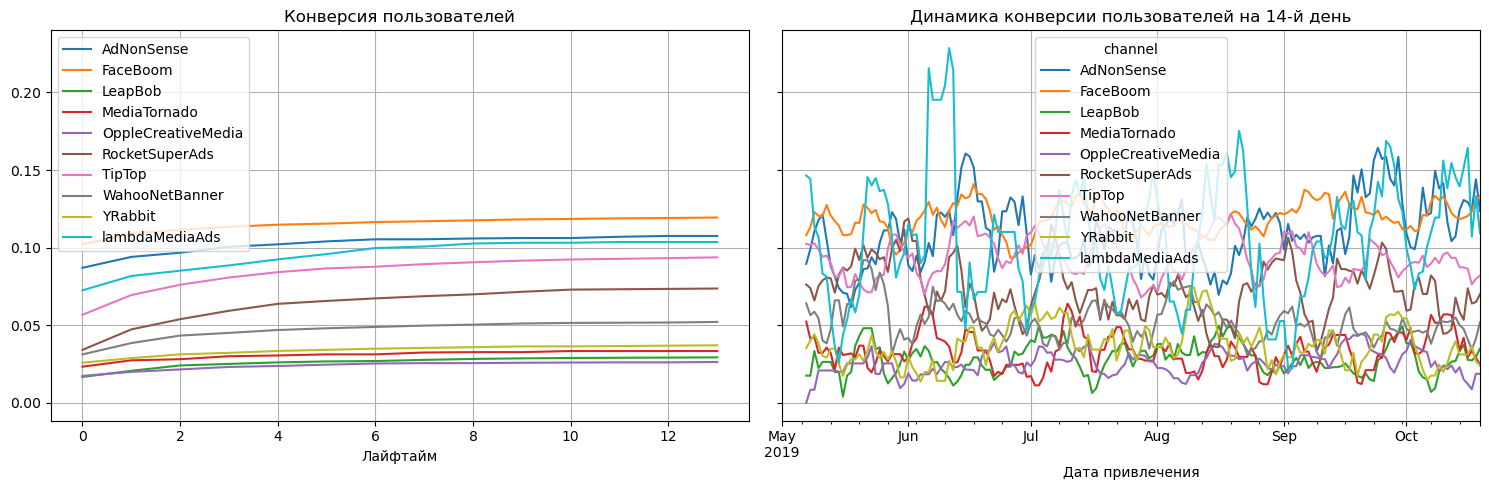

In [62]:
plot_conversion(conversion, conversion_history, 14) 

Проверили данные по конверсии в TipTop и FaceBoom: за исключением внутримесячных колебаний, она выглядит стабильной.\
По другим источникам заметных трендов не наблюдаем, большие сезонные колебания обусловлены малым количеством данных.

In [63]:
#Рассмотрим удержание пользователей в разбивке по каналам
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_dt, horizon, dimensions=['channel']
)

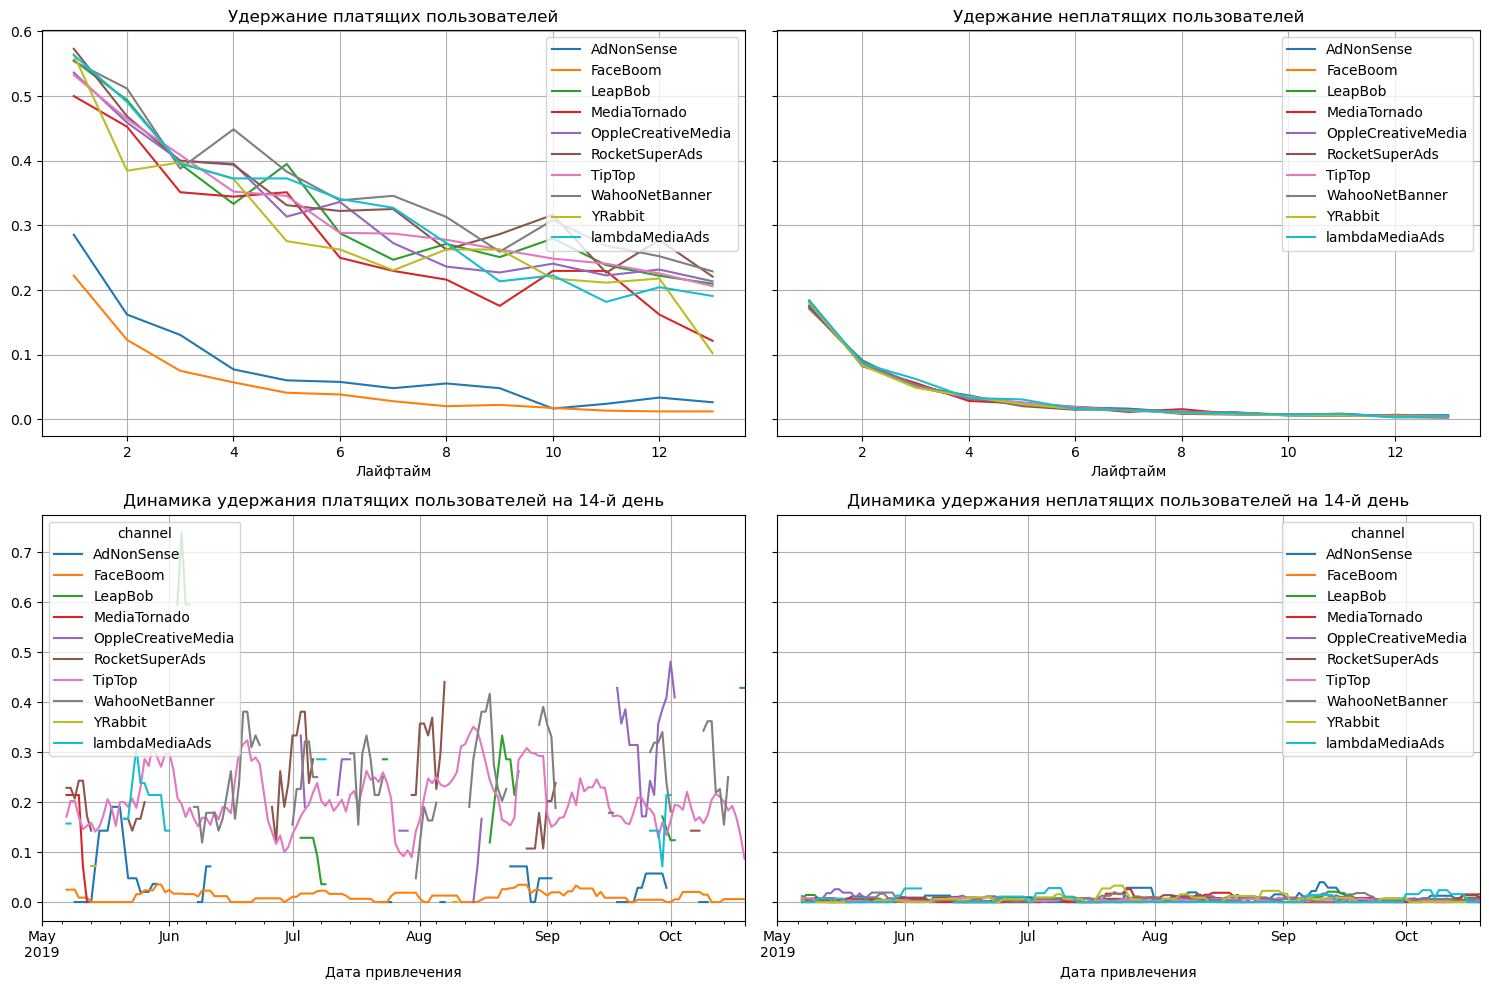

In [64]:
#Сформируем график удержания пользователей по лайфтаймам и в динамике по месяцам
plot_retention(retention, retention_history, 14) 

Видим, что несмотря на то, что FaceBoom и AdNonSense являются лидерами по конверсии, удержание у них одно из самых низких. Удержание TipTop примерно на уровне других каналов.\
Фрагментарность помесячной динамики обусловлена малым количеством данных по большей части каналов.

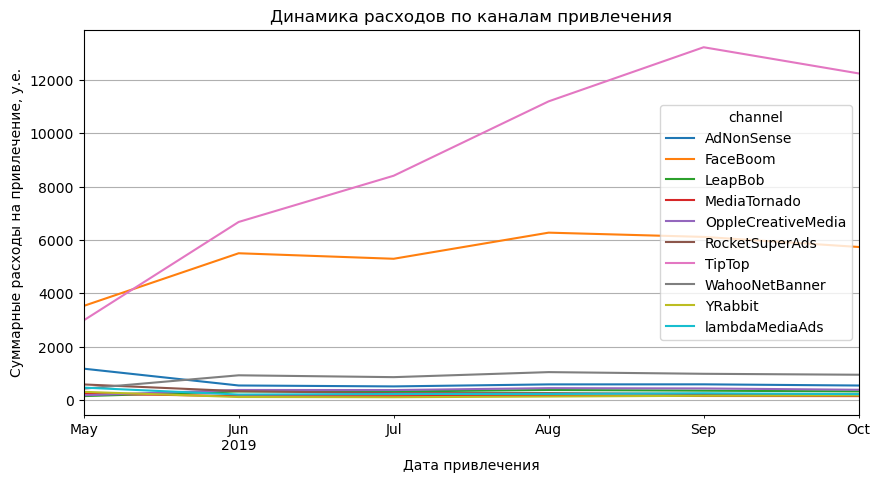

In [65]:
#Рассмотрим динамику расходов на рекламу в TipTop,FaceBoom
profiles.pivot_table(
    index='month', columns='channel', values='acquisition_cost', aggfunc='sum'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('Суммарные расходы на привлечение, у.е.')
plt.xlabel('Дата привлечения')
plt.title('Динамика расходов по каналам привлечения')
plt.show()

In [66]:
profiles.pivot_table(
    index='month', columns='channel', values='acquisition_cost', aggfunc='sum')

channel,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds
month,,,,,,,,,,
2019-05-01,1169.70,3524.4,140.28,238.56,169.75,577.980,2981.0,418.8,299.70,458.4
2019-06-01,538.65,5501.1,314.58,138.00,370.00,325.715,6675.6,921.0,106.20,199.2
2019-07-01,504.00,5294.3,313.53,138.48,366.50,252.070,8410.2,851.4,97.38,219.2
2019-08-01,579.60,6274.4,369.81,154.56,439.25,253.110,11202.0,1040.4,124.74,220.0
2019-09-01,581.70,6114.9,343.98,144.72,427.75,218.400,13232.5,977.4,152.79,247.2
2019-10-01,537.60,5736.5,315.42,140.16,378.00,205.725,12250.0,942.0,163.41,213.6


Инвестиции в TipTop динамично росли до сентября. Рост расходов на FaceBoom не такой высокий, но тоже значительно выше, чем по другим источникам.

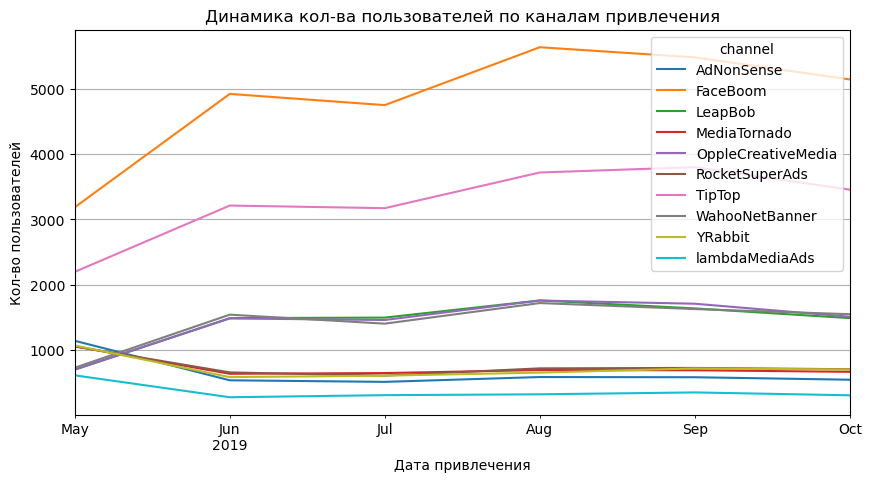

In [67]:
profiles.pivot_table(
    index='month', columns='channel', values='user_id', aggfunc='count'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('Кол-во пользователей')
plt.xlabel('Дата привлечения')
plt.title('Динамика кол-ва пользователей по каналам привлечения')
plt.show()

In [68]:
profiles.pivot_table(
    index='month', columns='channel', values='user_id', aggfunc='count'
)

channel,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds
month,,,,,,,,,,
2019-05-01,1138,3187,695,1052,697,1052,2196,725,1066,608
2019-06-01,532,4926,1486,632,1481,653,3213,1539,581,272
2019-07-01,508,4754,1494,643,1457,604,3173,1401,603,304
2019-08-01,582,5642,1757,689,1756,715,3720,1717,650,317
2019-09-01,579,5487,1635,686,1707,722,3802,1625,714,346
2019-10-01,541,5148,1486,662,1507,702,3457,1546,698,302


Динамика привлечения пользователей похоже на динамику затрат, однако она существенно более скромная: прирост на 46% против 124% по затратам в июне, спад на 1% против  прироста на 26% в июле и т.д. - динамика привлечения существенно отстает от динамики роста затрат.\
В то же время WahooNetBanner и LeapBob показали похожую положительную динамику даже без прироста инвестиций.

### 6. Общие выводы

Мы проанализировали данные пользовательских сессий, покупок и инвестиций в привлечение пользователей за период с 1 мая по 27 октября 2019 года. 


**1 На этапе предобработки данных** мы нормализовали названия столбцов и заменили типы данных в предоставленных датасетах. Дубликатов и пропусков в данных не обнаружили.


2 Для расчета метрик и построения графиков мы сформировали **набор функций**:

2.1 для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

2.2 для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.


**3 На этапе исследовательского анализа** данных мы выяснили, что 78% покупателей - из США, кроме того у этой страны наибольшая конверсия в покупки - 7% (у Германии, которая по конверсии на втором месте, всего 4,1%).\
Наибольшая часть (38%) платящих пользователей приходят с iPhone, а наилучшая конверсия у пользователей iPhone и Mac (6,2% и 6,4%).\
Большая часть покупателей привлечена через ресурсы TipTop и FaceBoom (40% и 21%), на третьем месте органический трафик (13%). Остальные источники привлекли не больше 5% от всех покупателей.


**4 Маркетинг**'
Общие расходы на маркетинг составили 105 тыс. у.е.
Наибольший объем инвестиций пришелся на ресурсы, которые привлекли больше всего покупателей - TipTop и FaceBoom (52% и 31% от всех расходов).\
Расходы на все источники привлечения за время наблюдения оставались примерно на одном уровне, кроме TipTop - инвестиции в этот источник росли экспоненциально.\
Лидеры по стоимости привлечения одного пользователя - те же TipTop и FaceBoom, но TipTop лидирует с более, чем двукратным отрывом (2,8 у.е. TipTop против 1,1 у.е. FaceBoom).


**5 Оценка окупаемости рекламы**
За весь период наблюдений реклама в целом не окупилась - ROI не достиг уровня окупаемости. Помесячная динамика ROI имеет стабильно негативный тренд с падением ниже уровня окупаемости в июне.\
CAC резко растет в мае и далее постепенно приростает в июне - октябре.\
LTV и конверсия прирастают мае, а затем на длинном промежутке времени остаются достаточно стабильными.\
Удержание снижается в июне и остается на примерно стабильном уровне до окончания периода наблюдений.

По результатам рассмотрения LTV, CAC и ROI в разрезе стран, устройств и каналов привлечения, можно сделать вывод о том, что общий негативный результат по ROI сформирован за счет **больших расходов на ресурсы, которые привлекали покупателей, которые не достигают окупаемости и имеют проблемы с удержанием.**.\

**Предложения**
1. Отказаться от привлечения через FaceBoom и AdNonSense, т.к. ROI этих ресурсов стабильно не окупался, а у FaceBoom ещё и удержание пользователей ниже, чем в других каналах. 
2. Инвестиции в привлечение через TipTop снизить до уровня мая 2019 года, когда ROI этого ресурса был положительным.
3. Высвободившиеся средства перераспределить между другими источниками с хорошей окупаемостью, например, WahooNetBanner, YRabbit и с осторожностью в lambdaMediaAds (осторожно, т.к. есть вопросы к удержанию клиентов из этого канала).
4. Проработать подходы для лучшего удержания пользователей из США, например с помощью введения персонализированных e-mail рассылок, персональных рекомендаций, push-уведомлений, скидок.